# Trabajo Práctico N°1 - Visión por Computadora I
---

Autores:
* Cattaneo, María Belén
* Ciarrapico, Nicolás Valentín
* Pryszczuk, Sabrina Daiana


In [1]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline  
#%matplotlib qt
import numpy as np #
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [2]:
# Función para mostrar imágenes que soporte subplots
def show_images(images, titles=None, cmap='gray'):
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap=cmap)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()


## Parte 1 - Algoritmo *White Patch* 
---

### 1. Implementar el algoritmo *White Patch* para librarnos de las diferencias de color de iluminación.

In [5]:
def get_max_pixel_values(image):
    """Devuelve los valores máximos de los canales R, G y B de la imagen."""
    return np.max(image[:, :, 0]), np.max(image[:, :, 1]), np.max(image[:, :, 2])

def apply_gain(image, R_max, G_max, B_max):
    """Aplica la ganancia a cada canal de la imagen según los valores máximos proporcionados."""
    gains = np.array([255.0 / R_max, 255.0 / G_max, 255.0 / B_max])
    corrected = np.clip(image * gains, 0, 255).astype(np.uint8)
    return corrected

def white_patch_correction(image):
    """Aplica la corrección de white patch a la imagen."""

    R_max, G_max, B_max = get_max_pixel_values(image)
    return apply_gain(image, R_max, G_max, B_max)

### 2. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de *White Patch*.

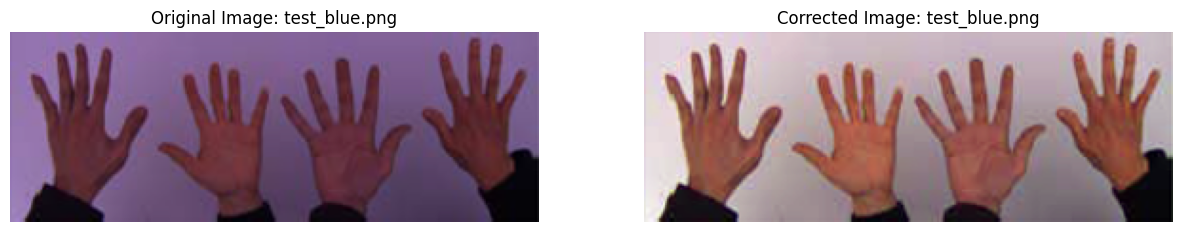

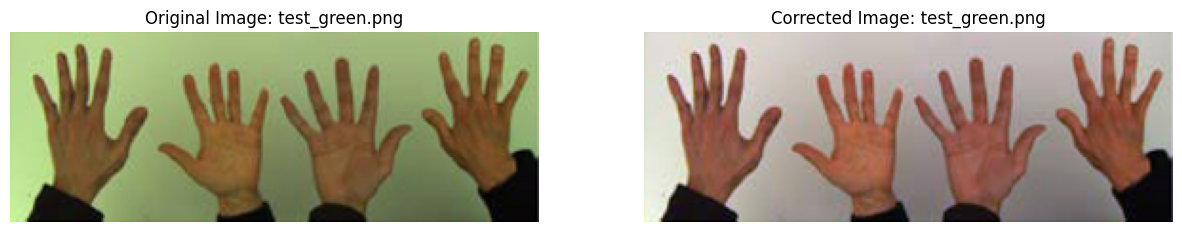

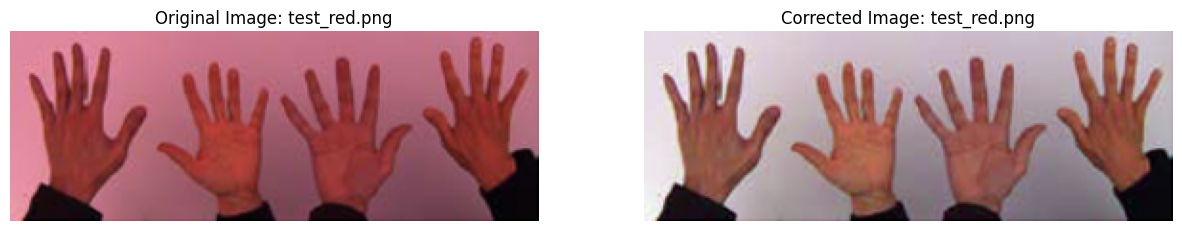

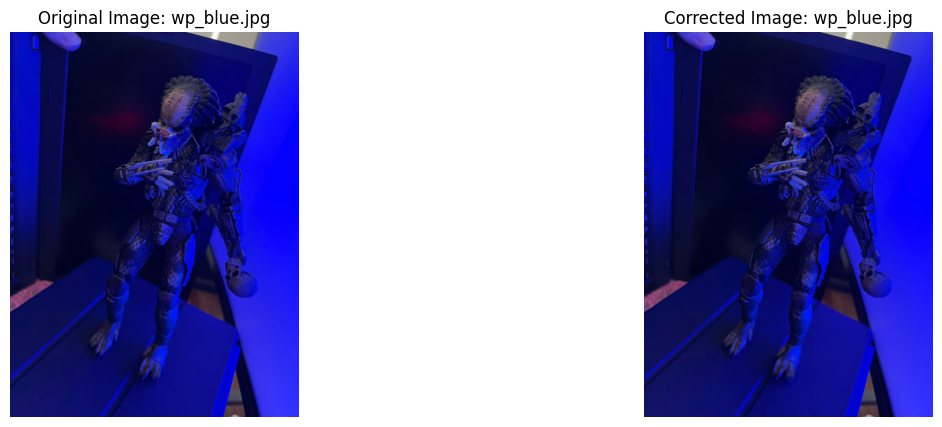

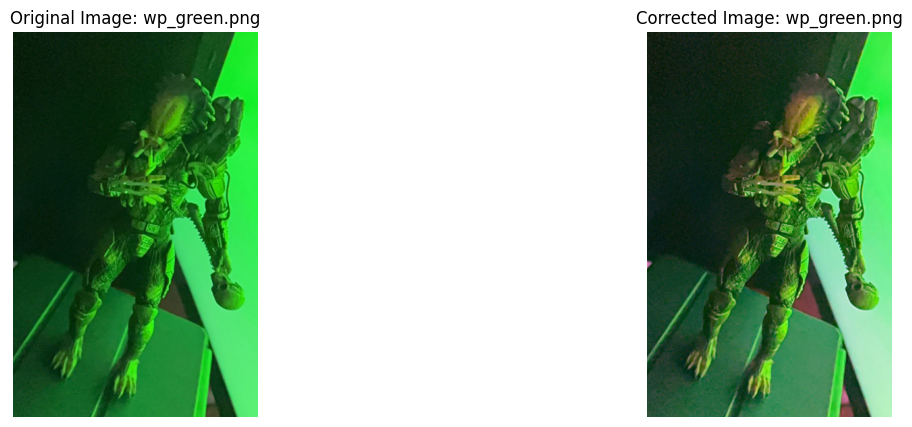

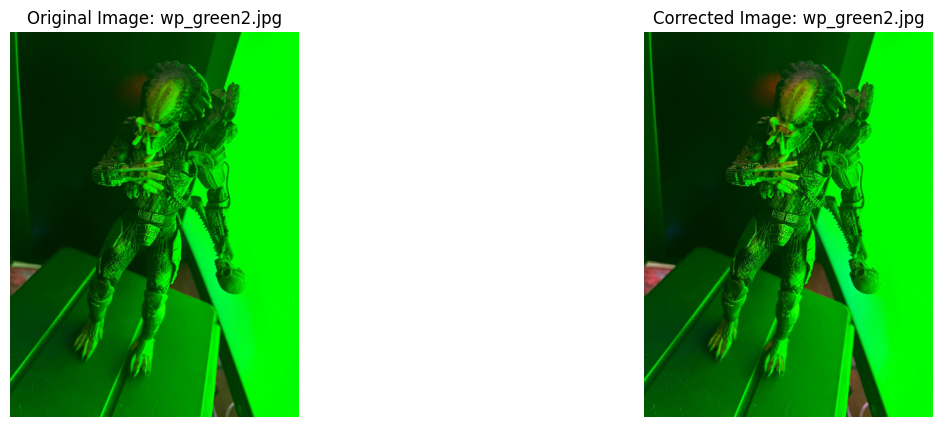

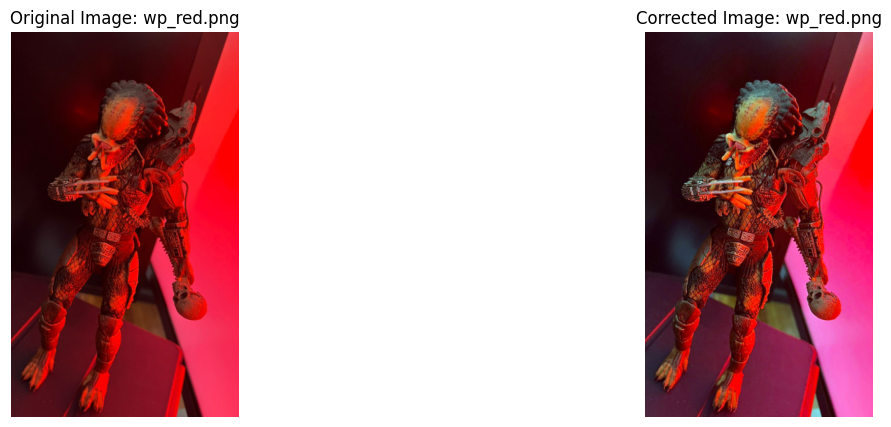

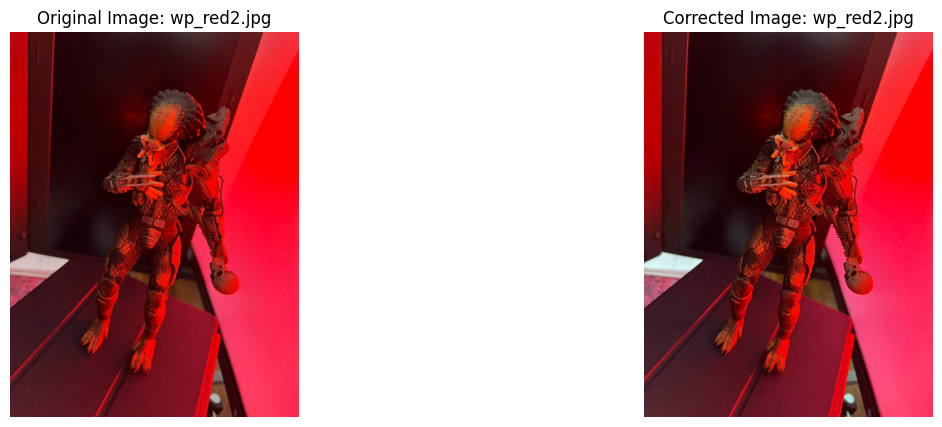

In [4]:
# Procesar todas las imágenes en la carpeta 'white_patch'

for image in sorted(os.listdir('white_patch')):
    if image.endswith('.png') or image.endswith('.jpg'):
        # Leer la imagen
        img = cv.imread(os.path.join('white_patch', image))
        # Convertir de BGR a RGB
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        # Aplicar la corrección de white patch
        corrected_img = white_patch_correction(img)
        
        # Mostrar las imágenes original y corregida
        show_images([img, corrected_img], titles=[f'Original Image: {image}', f'Corrected Image: {image}'])

#### Análisis de Resultados
El algoritmo White Patch se utiliza para la corrección del color en imágenes.
Toma el punto más claro de la imagen, asumiendo que este representa un color blanco verdadero, y utiliza ese valor para ajustar el resto de los píxeles.
A partir del valor máximo en cada canal (R, G, B), el algoritmo calcula una ganancia que se aplica a toda la imagen con el fin de normalizar los niveles de color y obtener una corrección global.

En los resultados obtenidos se observan dos comportamientos:
1. Imágenes de Manos: El algoritmo funcionó correctamente eliminando los tintes de color, ya que estas imágenes no tenían zonas saturadas artificialmente.
2. Imágenes de "Depredador" (wp_green, wp_red, etc.): Aquí el algoritmo falló (la imagen corregida se ve igual a la original). Esto sucede porque estas imágenes contienen brillos especulares (reflejos de luz pura en el plástico) que ya tienen el valor máximo de 255 en el canal dominante.

Al ser el máximo ya 255, el factor de ganancia calculado es $255/255 = 1$, por lo que no se aplica ninguna corrección. Para solucionar esto, es necesario modificar el algoritmo para que sea robusto a estos valores atípicos (*outliers*).

Para mejorar su robustez, a veces se reemplaza el valor máximo por un percentil alto (por ejemplo, el 95 %), lo que reduce la influencia de valores atípicos o ruidos.
Por otro lado, el algoritmo tiende a generar saturación, ya que al escalar los canales hasta 255 puede producir pérdida de detalle en las zonas más claras de la imagen.

### Implementación con Percentiles

In [15]:
def white_patch_correction(image, percentile=100):
    """
    Aplica el algoritmo White Patch para corrección de color.

    Esta implementación permite alternar entre el enfoque "Ingenuo" (Max-RGB) y 
    el enfoque "Robusto" mediante el uso de percentiles.
    
    El algoritmo asume que el valor más alto (o el percentil especificado) 
    en cada canal corresponde al "blanco verdadero" y escala los canales 
    para normalizar la iluminación.

    Args:
        image (numpy.ndarray): Imagen de entrada en formato RGB (no BGR).
        percentile (float, opcional): Valor del percentil a utilizar como referencia 
            del blanco (0-100). 
            - Use 100 para el algoritmo estándar (toma el máximo absoluto).
            - Use valores menores (ej. 97, 98, 99) para la versión robusta que 
              descarta outliers y brillos especulares. 
            Por defecto es 100.

    Returns:
        numpy.ndarray: La imagen corregida con balance de blancos aplicado, 
        en formato uint8 y rango [0, 255].
    """
    # Calculamos el valor del percentil para cada canal
    # np.percentile devuelve un float, lo cual es correcto para calcular la ganancia
    R_p = np.percentile(image[:, :, 0], percentile)
    G_p = np.percentile(image[:, :, 1], percentile)
    B_p = np.percentile(image[:, :, 2], percentile)
    
    # Aplicamos la ganancia usando esos valores como referencia de "blanco"
    # Nota: Si el percentil es menor al máximo real, la ganancia será > 1
    return apply_gain(image, R_p, G_p, B_p)

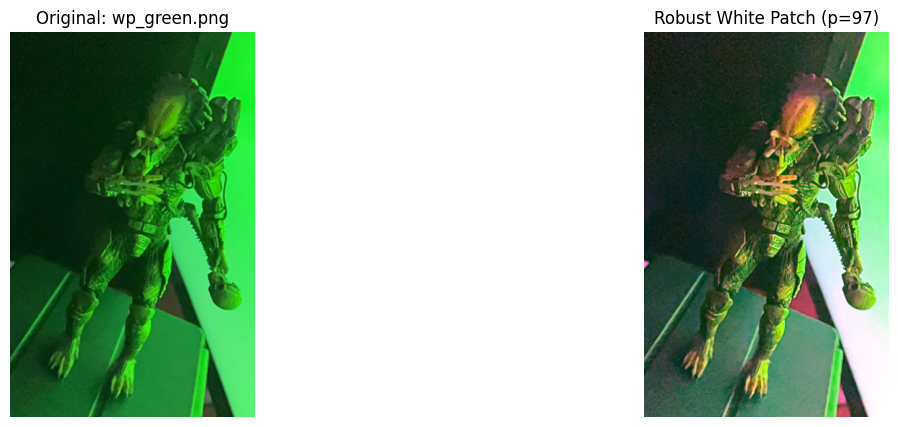

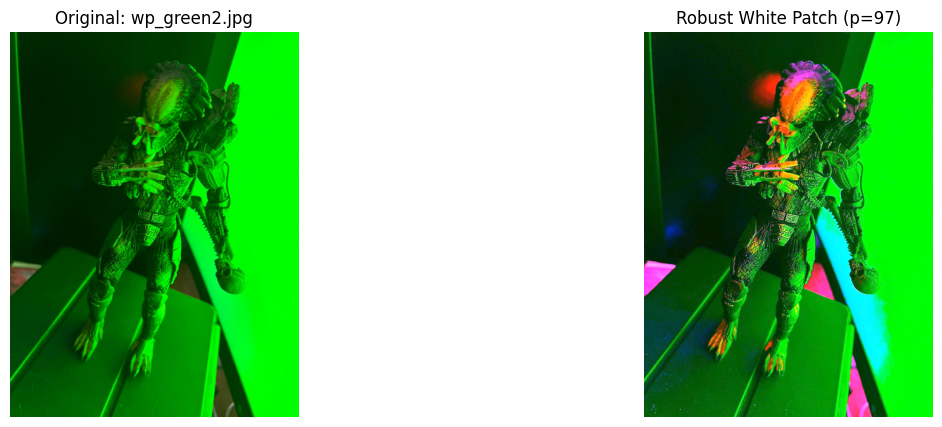

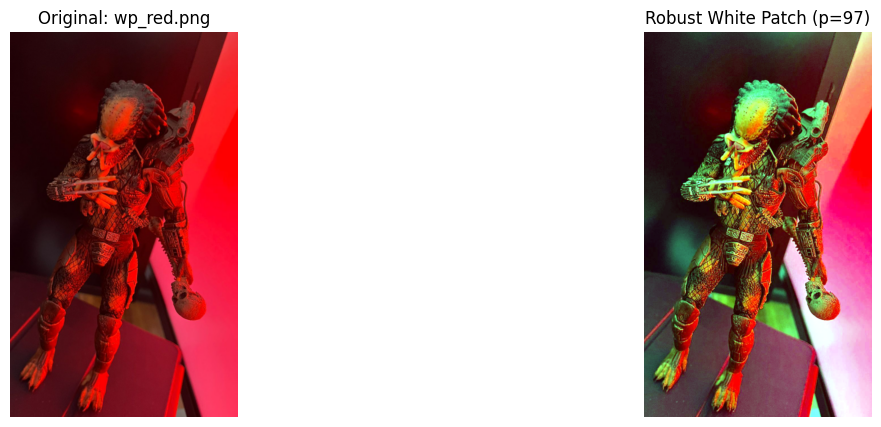

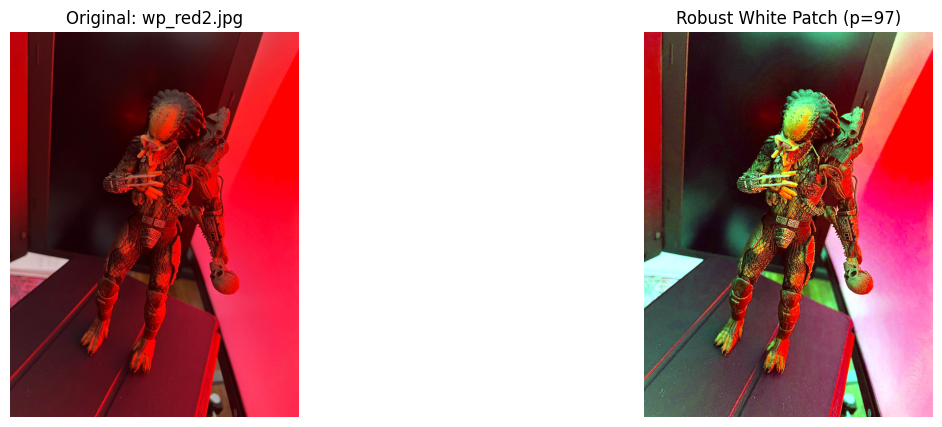

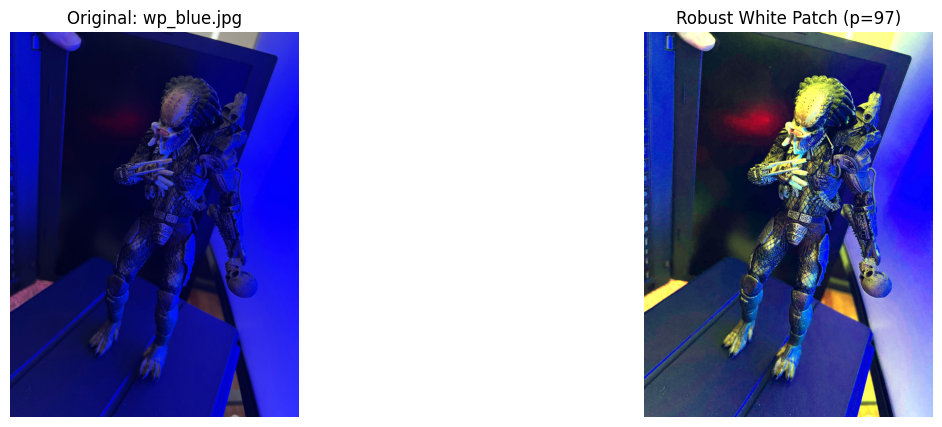

In [16]:
# Probamos con un percentil 97  para ignorar el 3% de pixeles más brillantes
percentil_test = 97

# Lista de imágenes que fallaron con el método estándar
problem_images = ['wp_green.png', 'wp_green2.jpg', 'wp_red.png', 'wp_red2.jpg', 'wp_blue.jpg']

for img_name in problem_images:
    path = os.path.join('white_patch', img_name)
    if os.path.exists(path):
        img = cv.imread(path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        # Aplicamos corrección con percentil
        corrected_img = white_patch_correction(img, percentile=percentil_test)
        
        show_images([img, corrected_img], 
                   titles=[f'Original: {img_name}', 
                           f'Robust White Patch (p={percentil_test})'])

#### Conclusiones

El algoritmo *White Patch* es una técnica sencilla y eficiente para la constancia del color, basándose en la teoría de la reflectancia. Sin embargo, su implementación ingenua (tomando el máximo absoluto) demostró ser insuficiente en escenarios reales donde existen fuentes de luz directa o materiales reflectantes (como el plástico de las figuras), ya que los brillos especulares saturan el sensor a 255, anulando la capacidad del algoritmo de calcular el factor de corrección.

Al implementar la variante basada en percentiles, logramos desestimar esos valores atípicos. Utilizando el percentil 97, el algoritmo pudo estimar correctamente el color de la iluminación basándose en la distribución global de la imagen y no en un solo píxel saturado, logrando recuperar los colores naturales de las figuras incluso bajo iluminaciones fuertemente teñidas.

## Parte 2 - Histogramas
---

### 1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y visualizarlas. 

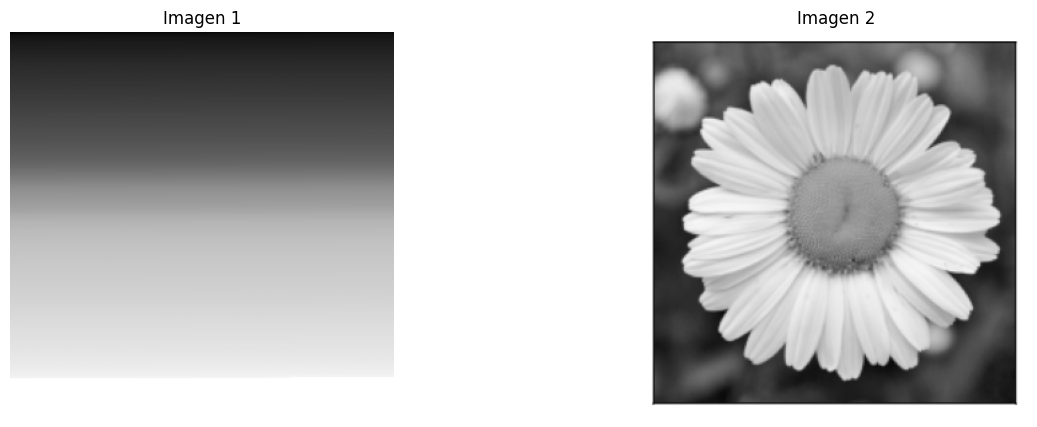

In [21]:
# Cargar las imagenes en escala de grises
img1 = cv.imread('img1_tp.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('img2_tp.png', cv.IMREAD_GRAYSCALE)

# Mostrar las imágenes
show_images([img1, img2], titles=['Imagen 1', 'Imagen 2'])


### 2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘features’ a los histogramas?

In [24]:
def plot_images_with_histograms(images, titles=None, bins_list=[256]):
    """
    Visualiza múltiples imágenes y sus histogramas correspondientes variando la cantidad de bins.

    Genera una figura de Matplotlib organizada en una grilla:
    - La primera fila muestra las imágenes originales en escala de grises.
    - Las filas subsiguientes muestran los histogramas calculados para cada imagen
      según los valores definidos en `bins_list`.

    Args:
        images (list[numpy.ndarray]): Lista de imágenes de entrada. Deben ser arrays 2D 
            (escala de grises), típicamente de tipo uint8.
        titles (list[str], opcional): Lista de títulos para cada imagen. 
            Si es None, se asignarán títulos genéricos (Ej: "Imagen 1").
            Debe coincidir en longitud con la lista `images`.
        bins_list (list[int], opcional): Lista de enteros que define las distintas 
            resoluciones (cantidad de bins) con las que se calcularán los histogramas.
            Por defecto es [32, 64, 128, 256].

    Returns:
        None: La función renderiza el gráfico directamente (plt.show()).
    """
    n_imgs = len(images)
    n_bins = len(bins_list)

    if titles is None:
        titles = [f'Imagen {i+1}' for i in range(n_imgs)]

    fig, axes = plt.subplots(n_bins + 1, n_imgs, figsize=(10, 3 * (n_bins + 1)))
    axes = np.atleast_2d(axes)

    # --- Fila 1: Imágenes ---
    for j, img in enumerate(images):
        ax = axes[0, j]
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.set_title(titles[j])
        ax.axis('off')

    # --- Filas siguientes: Histogramas ---
    for i, n_bins_val in enumerate(bins_list, start=1):
        for j, img in enumerate(images):
            ax = axes[i, j]
            
            
            ax.hist(img.ravel(), bins=n_bins_val, range=[0, 256], color='black', alpha=0.7)
            
            ax.set_xlim([0, 256]) 
            
            if j == 0:
                ax.set_ylabel(f'{n_bins_val} bins')
            if i == n_bins:
                ax.set_xlabel('Intensidad (0-255)')

    plt.tight_layout()
    plt.show()

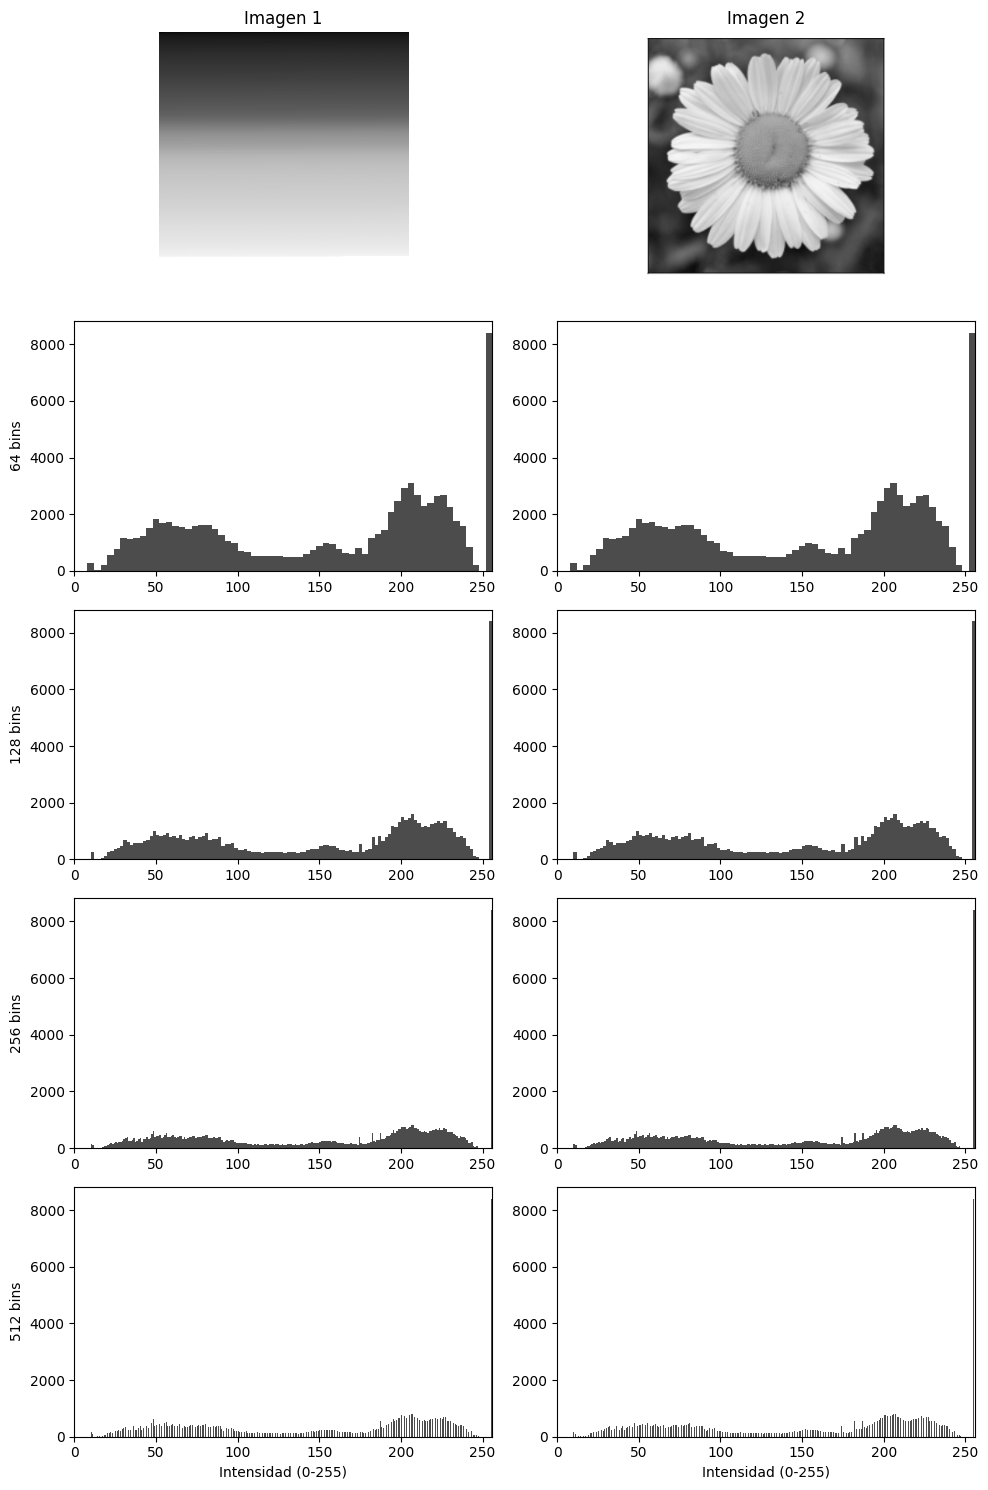

In [25]:
plot_images_with_histograms([img1, img2], bins_list=[64, 128, 256, 512])

#### Conclusiones

1. Sobre la elección del número de bins:
   
   Dependiendo del nivel de detalle que se requiera, la elección de la cantidad de bins es clave. Una cantidad baja (ej. 64) agrupa los valores, mostrando una tendencia general y suavizando "ruidos". Para analizar la distribución tonal completa de una imagen de 8 bits, 256 bins es lo más adecuado, ya que permite representar la frecuencia de cada nivel de intensidad posible (0-255) sin pérdida de información.
3. Comparación de los histogramas:
   
   Al comparar los histogramas de Imagen 1 (Gradiente) e Imagen 2 (Flor), observamos un fenómeno contraintuitivo: ambas distribuciones son prácticamente idénticas. A pesar de que visualmente la Imagen 2 es compleja y heterogénea (la flor) y la Imagen 1 parece un gradiente suave. Esto podría ser porque la Imagen 1 es, en realidad, una reconstrucción sintética donde se tomaron los píxeles de la Imagen 2 y se ordenaron por intensidad. Esto demuestra que el histograma representa la población de los datos, pero ignora completamente su ubicación.
5. Utilidad como *features*:
   
   El histograma puede utilizarse como descriptor para clasificar imágenes, aunque con limitaciones. Es excelente para clasificar imágenes basándose en propiedades globales como la iluminación (fotos oscuras vs. claras), el contraste, o la distribución de color (ej. distinguir un "bosque" de un "desierto" por la predominancia de verdes o amarillos). Sin embargo, como demostramos en este TP, el histograma no conserva información espacial. Un modelo basado únicamente en histogramas no podría distinguir entre una flor y un gradiente ordenado de sus píxeles, ni detectar formas o bordes. Por ende, para detección de objetos específicos, el histograma es insuficiente por sí solo y debe complementarse con técnicas que analicen la estructura espacial